### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [20]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [21]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'D:/機器學習-課程/第一屆深度學習與電腦視覺馬拉松/data/training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [23]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [24]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [25]:
# 印出網路結構
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         73856     
__________

In [26]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [27]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0070 - val_loss: 0.0023

Epoch 00001: val_loss improved from inf to 0.00229, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 1s 446us/step - loss: 0.0018 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00229 to 0.00189, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 1s 478us/step - loss: 0.0015 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00189 to 0.00188, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 1s 486us/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00004: val_loss did not improve from 0.00188
Epoch 5/150
1712/1712 [==============================] - 1s 397us/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00005: val_loss did not improve from 0.00188
Epoch 6/150
1712/1712 [==============================] - 1s 434

1712/1712 [==============================] - 1s 424us/step - loss: 2.1479e-04 - val_loss: 8.0751e-04

Epoch 00045: val_loss did not improve from 0.00078
Epoch 46/150
1712/1712 [==============================] - 1s 430us/step - loss: 2.1163e-04 - val_loss: 7.9238e-04

Epoch 00046: val_loss did not improve from 0.00078
Epoch 47/150
1712/1712 [==============================] - 1s 428us/step - loss: 2.1131e-04 - val_loss: 7.9518e-04

Epoch 00047: val_loss did not improve from 0.00078
Epoch 48/150
1712/1712 [==============================] - 1s 420us/step - loss: 2.1051e-04 - val_loss: 7.8028e-04

Epoch 00048: val_loss improved from 0.00078 to 0.00078, saving model to best_weights.h5
Epoch 49/150
1712/1712 [==============================] - 1s 436us/step - loss: 2.0581e-04 - val_loss: 7.9259e-04

Epoch 00049: val_loss did not improve from 0.00078
Epoch 50/150
1712/1712 [==============================] - 1s 426us/step - loss: 2.0797e-04 - val_loss: 7.8163e-04

Epoch 00050: val_loss did not i

1712/1712 [==============================] - 1s 441us/step - loss: 1.3547e-04 - val_loss: 7.5567e-04

Epoch 00093: val_loss improved from 0.00076 to 0.00076, saving model to best_weights.h5
Epoch 94/150
1712/1712 [==============================] - 1s 459us/step - loss: 1.2907e-04 - val_loss: 7.7943e-04

Epoch 00094: val_loss did not improve from 0.00076
Epoch 95/150
1712/1712 [==============================] - 1s 486us/step - loss: 1.3195e-04 - val_loss: 7.8354e-04

Epoch 00095: val_loss did not improve from 0.00076
Epoch 96/150
1712/1712 [==============================] - 1s 463us/step - loss: 1.3205e-04 - val_loss: 7.7529e-04

Epoch 00096: val_loss did not improve from 0.00076
Epoch 97/150
1712/1712 [==============================] - 1s 492us/step - loss: 1.3060e-04 - val_loss: 7.5839e-04

Epoch 00097: val_loss did not improve from 0.00076
Epoch 98/150
1712/1712 [==============================] - 1s 538us/step - loss: 1.2513e-04 - val_loss: 7.7992e-04

Epoch 00098: val_loss did not i

1712/1712 [==============================] - 1s 433us/step - loss: 9.8427e-05 - val_loss: 7.4797e-04

Epoch 00141: val_loss did not improve from 0.00075
Epoch 142/150
1712/1712 [==============================] - 1s 430us/step - loss: 9.7805e-05 - val_loss: 7.6999e-04

Epoch 00142: val_loss did not improve from 0.00075
Epoch 143/150
1712/1712 [==============================] - 1s 415us/step - loss: 9.4824e-05 - val_loss: 7.5817e-04

Epoch 00143: val_loss did not improve from 0.00075
Epoch 144/150
1712/1712 [==============================] - 1s 402us/step - loss: 9.6952e-05 - val_loss: 7.7371e-04

Epoch 00144: val_loss did not improve from 0.00075
Epoch 145/150
1712/1712 [==============================] - 1s 461us/step - loss: 9.4215e-05 - val_loss: 7.8276e-04

Epoch 00145: val_loss did not improve from 0.00075
Epoch 146/150
1712/1712 [==============================] - 1s 464us/step - loss: 9.4611e-05 - val_loss: 7.9057e-04

Epoch 00146: val_loss did not improve from 0.00075
Epoch 147/15

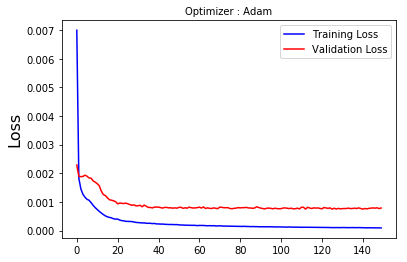

In [28]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [29]:
# 讀取測試資料集
imgs_test, points_test = load_data(dirname = 'D:/機器學習-課程/第一屆深度學習與電腦視覺馬拉松/data/test.csv')

In [30]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

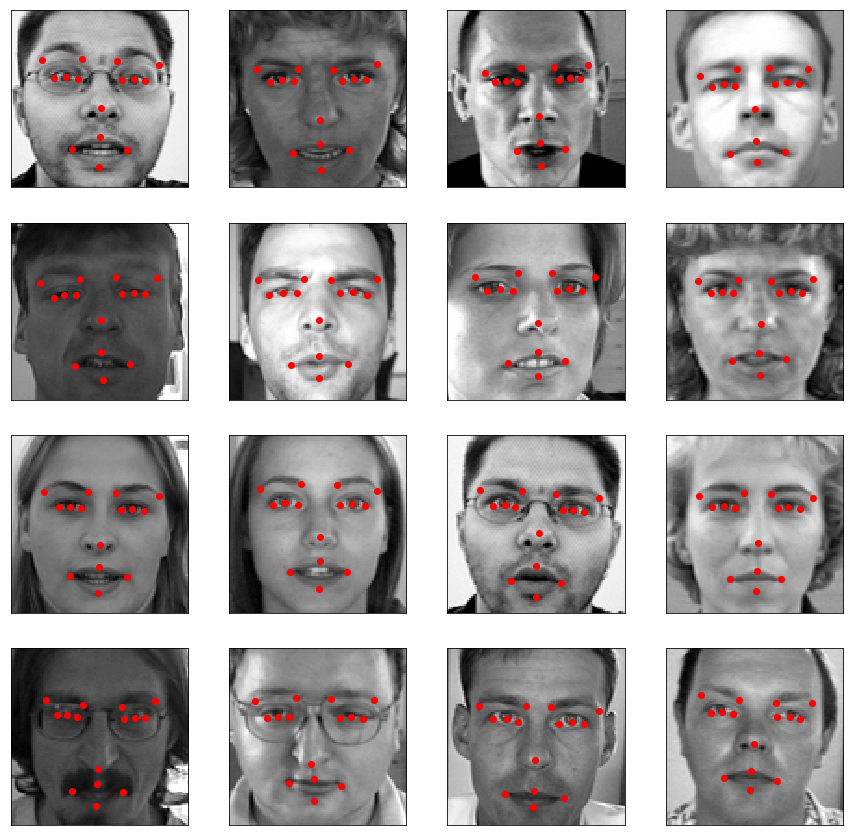

In [31]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [47]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [50]:
# Your code
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip = True)
train_image = imgs_train.reshape(-1, 96, 96, 1)
train_generator = datagen.flow(train_image, points_train,batch_size = 8)
hist_model=model_with_augment.fit_generator(train_generator, steps_per_epoch=len(train_image)//8,epochs=50,
                                 callbacks=[checkpoint, hist],shuffle=True,verbose=1,
                                validation_data=(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1), points_test))

Epoch 1/50
267/267 [==============================] - 5s 18ms/step - loss: 0.0021 - val_loss: 8.8711e-04

Epoch 00001: val_loss did not improve from 0.00074
Epoch 2/50
267/267 [==============================] - 3s 13ms/step - loss: 0.0012 - val_loss: 6.9415e-04

Epoch 00002: val_loss improved from 0.00074 to 0.00069, saving model to best_weights.h5
Epoch 3/50
267/267 [==============================] - 4s 14ms/step - loss: 8.9164e-04 - val_loss: 5.7441e-04

Epoch 00003: val_loss improved from 0.00069 to 0.00057, saving model to best_weights.h5
Epoch 4/50
267/267 [==============================] - 3s 13ms/step - loss: 8.0291e-04 - val_loss: 5.5652e-04

Epoch 00004: val_loss improved from 0.00057 to 0.00056, saving model to best_weights.h5
Epoch 5/50
267/267 [==============================] - 4s 14ms/step - loss: 7.3906e-04 - val_loss: 5.0593e-04

Epoch 00005: val_loss improved from 0.00056 to 0.00051, saving model to best_weights.h5
Epoch 6/50
267/267 [==============================] - 4

267/267 [==============================] - 4s 15ms/step - loss: 2.8308e-04 - val_loss: 5.8085e-04

Epoch 00050: val_loss did not improve from 0.00047


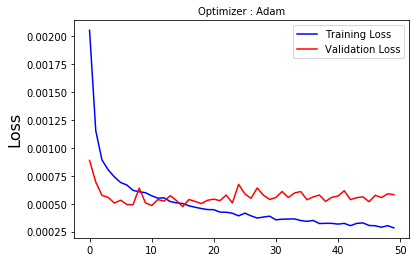

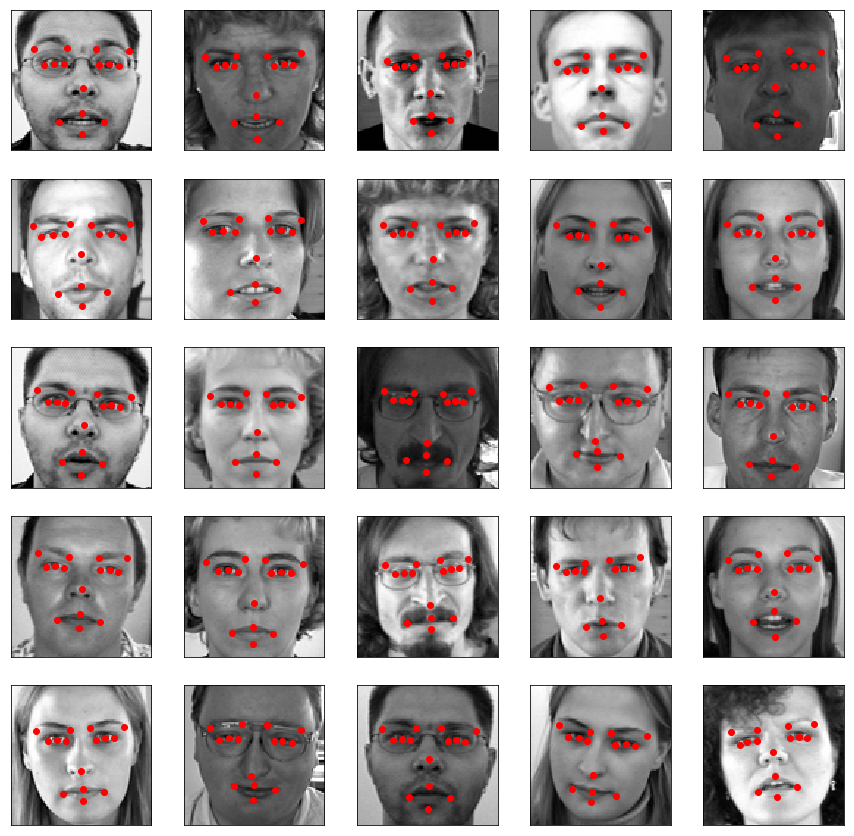

In [53]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')
        
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

In [55]:
# Your code
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip = True,
                             zoom_range = [0.8 , 1.2 ],
                             rotation_range = 30 ,
                             width_shift_range = 10.0 , 
                             height_shift_range = 10.0 )
train_image = imgs_train.reshape(-1, 96, 96, 1)
train_generator = datagen.flow(train_image, points_train,batch_size = 8)
hist_model=model_with_augment.fit_generator(train_generator, steps_per_epoch=len(train_image)//8,epochs=50,
                                 callbacks=[checkpoint, hist],shuffle=True,verbose=1,
                                validation_data=(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1), points_test))

Epoch 1/50
267/267 [==============================] - 5s 18ms/step - loss: 0.0011 - val_loss: 7.9127e-04

Epoch 00001: val_loss did not improve from 0.00047
Epoch 2/50
267/267 [==============================] - 4s 15ms/step - loss: 9.9185e-04 - val_loss: 6.3670e-04

Epoch 00002: val_loss did not improve from 0.00047
Epoch 3/50
267/267 [==============================] - 4s 16ms/step - loss: 9.4928e-04 - val_loss: 6.8922e-04

Epoch 00003: val_loss did not improve from 0.00047
Epoch 4/50
267/267 [==============================] - 4s 16ms/step - loss: 9.2458e-04 - val_loss: 6.9228e-04

Epoch 00004: val_loss did not improve from 0.00047
Epoch 5/50
267/267 [==============================] - 4s 15ms/step - loss: 8.8922e-04 - val_loss: 6.5068e-04

Epoch 00005: val_loss did not improve from 0.00047
Epoch 6/50
267/267 [==============================] - 4s 15ms/step - loss: 8.8671e-04 - val_loss: 6.6906e-04

Epoch 00006: val_loss did not improve from 0.00047
Epoch 7/50
267/267 [==================

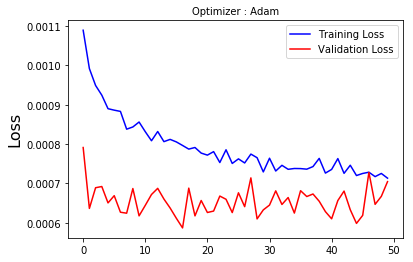

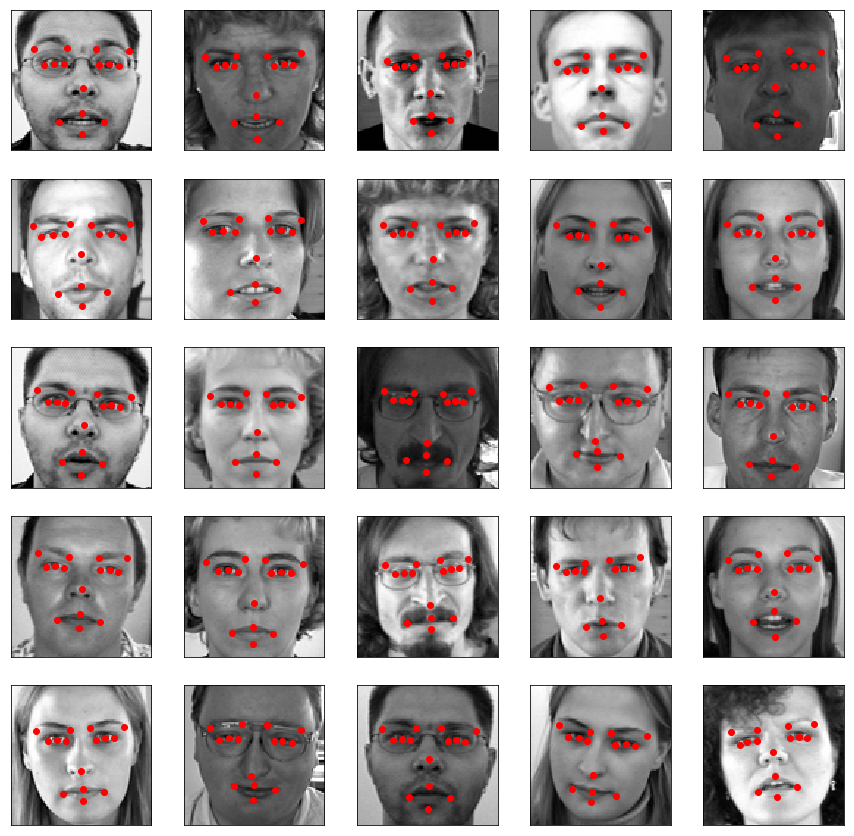

In [58]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')
        
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import dtypes
%matplotlib inline
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras_lookahead import Lookahead
from keras_radam import RAdam
Ranger=Lookahead(RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=1e-5))

def pairwise_distance(feature, squared=False):
    """Computes the pairwise distance matrix with numerical stability.

    output[i, j] = || feature[i, :] - feature[j, :] ||_2

    Args:
      feature: 2-D Tensor of size [number of data, feature dimension].
      squared: Boolean, whether or not to square the pairwise distances.

    Returns:
      pairwise_distances: 2-D Tensor of size [number of data, number of data].
    """
    pairwise_distances_squared = math_ops.add(
        math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
        math_ops.reduce_sum(
            math_ops.square(array_ops.transpose(feature)),
            axis=[0],
            keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                    array_ops.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = math_ops.sqrt(
            pairwise_distances_squared + math_ops.to_float(error_mask) * 1e-16)

    # Undo conditionally adding 1e-16.
    pairwise_distances = math_ops.multiply(
        pairwise_distances, math_ops.to_float(math_ops.logical_not(error_mask)))

    num_data = array_ops.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
        array_ops.ones([num_data]))
    pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances

def masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the maximum.

    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
    masked_maximums = math_ops.reduce_max(
        math_ops.multiply(data - axis_minimums, mask), dim,
        keepdims=True) + axis_minimums
    return masked_maximums

def masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.

    Args:
      data: 2-D float `Tensor` of size [n, m].
      mask: 2-D Boolean `Tensor` of size [n, m].
      dim: The dimension over which to compute the minimum.

    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
    masked_minimums = math_ops.reduce_min(
        math_ops.multiply(data - axis_maximums, mask), dim,
        keepdims=True) + axis_maximums
    return masked_minimums

def triplet_loss_adapted_from_tf(y_true, y_pred):
    del y_true
    margin = 1.
    labels = y_pred[:, :1]

 
    labels = tf.cast(labels, dtype='int32')

    embeddings = y_pred[:, 1:]

    ### Code from Tensorflow function [tf.contrib.losses.metric_learning.triplet_semihard_loss] starts here:
    
    # Reshape [batch_size] label tensor to a [batch_size, 1] label tensor.
    # lshape=array_ops.shape(labels)
    # assert lshape.shape == 1
    # labels = array_ops.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    pdist_matrix = pairwise_distance(embeddings, squared=True)
    # Build pairwise binary adjacency matrix.
    adjacency = math_ops.equal(labels, array_ops.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = math_ops.logical_not(adjacency)

    # global batch_size  
    batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

    # Compute the mask.
    pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
    mask = math_ops.logical_and(
        array_ops.tile(adjacency_not, [batch_size, 1]),
        math_ops.greater(
            pdist_matrix_tile, array_ops.reshape(
                array_ops.transpose(pdist_matrix), [-1, 1])))
    mask_final = array_ops.reshape(
        math_ops.greater(
            math_ops.reduce_sum(
                math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
            0.0), [batch_size, batch_size])
    mask_final = array_ops.transpose(mask_final)

    adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
    mask = math_ops.cast(mask, dtype=dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = array_ops.reshape(
        masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
    negatives_outside = array_ops.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = array_ops.tile(
        masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
    semi_hard_negatives = array_ops.where(
        mask_final, negatives_outside, negatives_inside)

    loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = math_ops.cast(
        adjacency, dtype=dtypes.float32) - array_ops.diag(
        array_ops.ones([batch_size]))

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = math_ops.reduce_sum(mask_positives)

    semi_hard_triplet_loss_distance = math_ops.truediv(
        math_ops.reduce_sum(
            math_ops.maximum(
                math_ops.multiply(loss_mat, mask_positives), 0.0)),
        num_positives,
        name='triplet_semihard_loss')
    
    ### Code from Tensorflow function semi-hard triplet loss ENDS here.
    return semi_hard_triplet_loss_distance

In [81]:
model_with_augment = get_model()
model_with_augment.compile(loss=triplet_loss_adapted_from_tf, optimizer=Ranger)
# Your code
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(horizontal_flip = True,
                             zoom_range = [0.8 , 1.2 ],
                             rotation_range = 30 ,
                             width_shift_range = 10.0 , 
                             height_shift_range = 10.0 )
train_image = imgs_train.reshape(-1, 96, 96, 1)
train_generator = datagen.flow(train_image, points_train,batch_size = 8)
hist_model=model_with_augment.fit_generator(train_generator, steps_per_epoch=len(train_image)//8,epochs=10,
                                 callbacks=[checkpoint, hist],shuffle=True,verbose=1,
                                validation_data=(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1), points_test))

Epoch 1/10
267/267 [==============================] - 7s 27ms/step - loss: 1.0039 - val_loss: 1.0000

Epoch 00001: val_loss did not improve from 0.00047
Epoch 2/10
267/267 [==============================] - 5s 19ms/step - loss: 1.0000 - val_loss: 1.0000

Epoch 00002: val_loss did not improve from 0.00047
Epoch 3/10
267/267 [==============================] - 5s 19ms/step - loss: 1.0000 - val_loss: 1.0000

Epoch 00003: val_loss did not improve from 0.00047
Epoch 4/10
267/267 [==============================] - 5s 21ms/step - loss: 1.0000 - val_loss: 1.0000

Epoch 00004: val_loss did not improve from 0.00047
Epoch 5/10
267/267 [==============================] - 5s 20ms/step - loss: 1.0000 - val_loss: 1.0000

Epoch 00005: val_loss did not improve from 0.00047
Epoch 6/10
267/267 [==============================] - 5s 19ms/step - loss: 1.0000 - val_loss: 1.0000

Epoch 00006: val_loss did not improve from 0.00047
Epoch 7/10
267/267 [==============================] - 5s 20ms/step - loss: 1.0000 

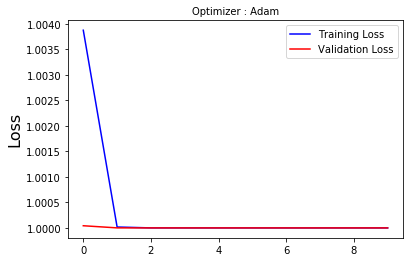

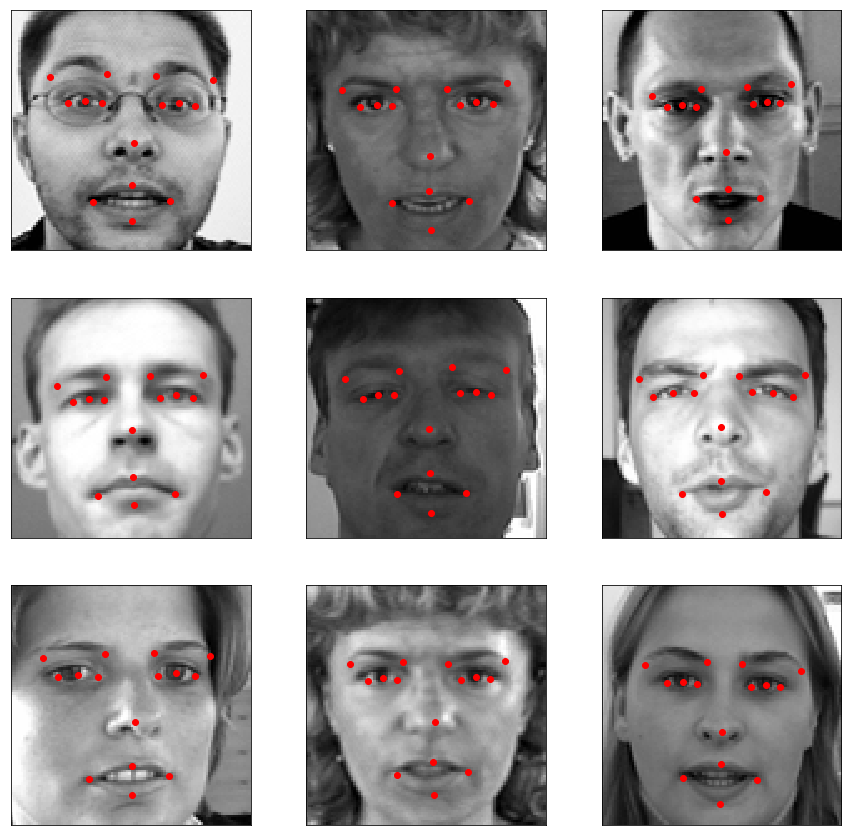

In [82]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')
        
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

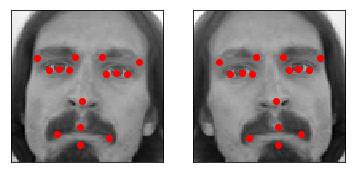

In [32]:
# 實現圖片以及關機點 label 做左右翻轉的函數
def augment_data(img, points):
    rows, cols = img.shape
    new_img = np.copy(img)
    
    # 翻轉圖片
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
            
    # 翻轉關鍵點 label
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
    
    # 調整對稱的 label
    new_points_temp = np.copy(new_points)
    new_points[0:2] = new_points_temp[2:4]
    new_points[2:4] = new_points_temp[0:2]
    new_points[4:6] = new_points_temp[8:10]
    new_points[6:8] = new_points_temp[10:12]
    new_points[8:10] = new_points_temp[4:6]
    new_points[10:12] = new_points_temp[6:8]
    new_points[12:14] = new_points_temp[16:18]
    new_points[14:16] = new_points_temp[18:20]
    new_points[16:18] = new_points_temp[12:14]
    new_points[18:20] = new_points_temp[14:16]
    new_points[22:24] = new_points_temp[24:26]
    new_points[24:26] = new_points_temp[22:24]
        
    return new_img, new_points

flip_img, flip_points = augment_data(imgs_train[0], points_train[0])

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_keypoints(imgs_train[0], points_train[0]) # 原來的圖片
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_keypoints(flip_img, flip_points) # 翻轉後的圖片

In [33]:
# 創建 list
aug_imgs_train = []
aug_points_train = []

# 對所有原始資料做 augmentation
for i in range(imgs_train.shape[0]):
    # 做左右翻轉
    aug_img, aug_point = augment_data(imgs_train[i], points_train[i])
    
    # append 原始資料
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # append 做過 augmentation 後的資料
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

(4280, 96, 96)
(4280, 30)


In [41]:
model_with_augment = get_model()
model_with_augment.compile(loss=triplet_loss_adapted_from_tf, optimizer=Ranger)
# Your code
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(zoom_range = [0.8 , 1.2 ] )
train_image = aug_imgs_train.reshape(-1, 96, 96, 1)
train_generator = datagen.flow(train_image, aug_points_train,batch_size = 8)
hist_model=model_with_augment.fit_generator(train_generator, steps_per_epoch=len(train_image)//8,epochs=10,
                                 callbacks=[checkpoint, hist],shuffle=True,verbose=1,
                                validation_data=(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1), points_test))

Epoch 1/10
535/535 [==============================] - 13s 24ms/step - loss: 1.0004 - val_loss: 1.0000

Epoch 00001: val_loss did not improve from 0.00075
Epoch 2/10
535/535 [==============================] - 10s 19ms/step - loss: 1.0000 - val_loss: 1.0000

Epoch 00002: val_loss did not improve from 0.00075
Epoch 3/10
535/535 [==============================] - 10s 19ms/step - loss: 1.0000 - val_loss: 1.0000

Epoch 00003: val_loss did not improve from 0.00075
Epoch 4/10
535/535 [==============================] - 9s 17ms/step - loss: 1.0000 - val_loss: 1.0000

Epoch 00004: val_loss did not improve from 0.00075
Epoch 5/10
535/535 [==============================] - 10s 19ms/step - loss: 1.0000 - val_loss: 1.0000

Epoch 00005: val_loss did not improve from 0.00075
Epoch 6/10
535/535 [==============================] - 10s 18ms/step - loss: 1.0000 - val_loss: 1.0000

Epoch 00006: val_loss did not improve from 0.00075
Epoch 7/10
535/535 [==============================] - 9s 17ms/step - loss: 1.

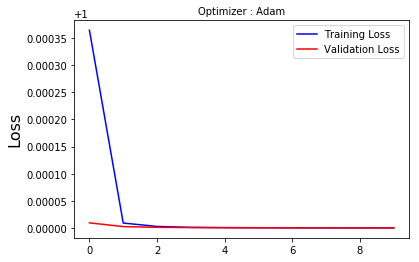

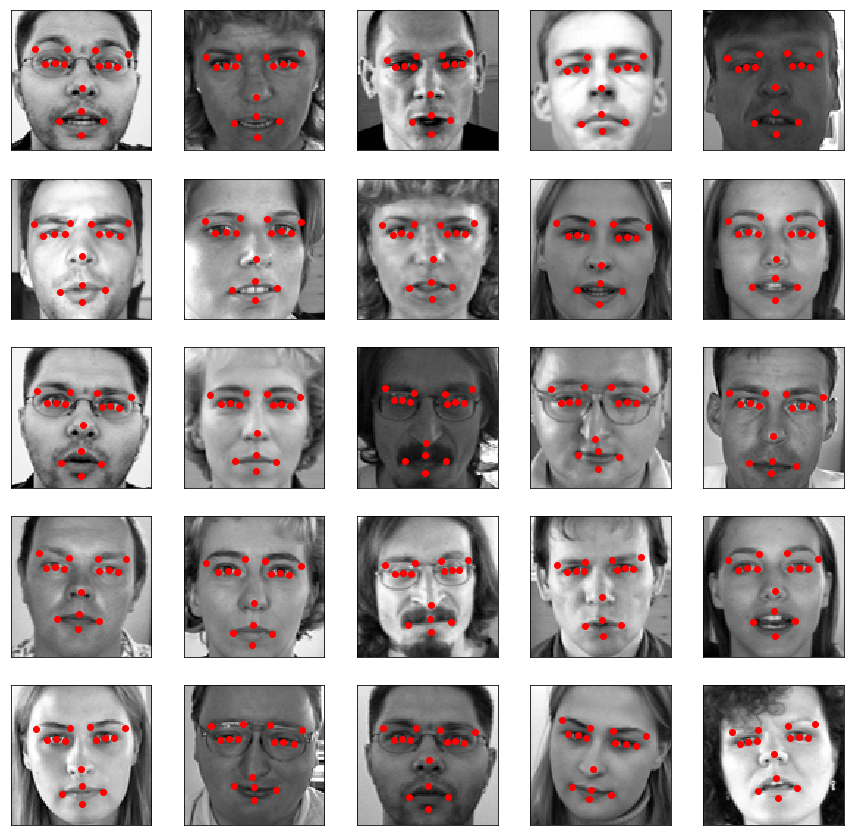

In [42]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')
        
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))